In [107]:
!pip install segmentation-models-pytorch;
!pip install -U git+https://github.com/albumentations-team/albumentations;
!pip install --upgrade opencv-contrib-python;

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-c2la4hzy
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-c2la4hzy
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 30.34 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [108]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [124]:
#VISUALIZATION FUNCTION
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')


In [115]:
#SETUP CONFIGURATIONS
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'
EPOCHS = 100
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16
ENCODER_NAME = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [15]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

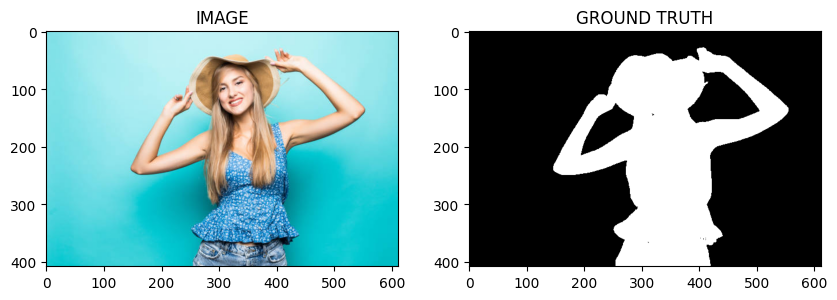

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [89]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42) #DATA SPLIT

In [19]:
import albumentations as A #albumentation documentation : https://albumentations.ai/docs/

In [83]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes=False)


def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes=False)

In [84]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations


  def __len__(self):
    return len(self.df)


  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [90]:
dataset_train = SegmentationDataset(train_df, get_train_augs())
dataset_test = SegmentationDataset(test_df, get_valid_augs())

In [86]:
print(f"Size of Trainset : {len(dataset_train)}")
print(f"Size of Validset : {len(dataset_test)}")

Size of Trainset : 232
Size of Validset : 58


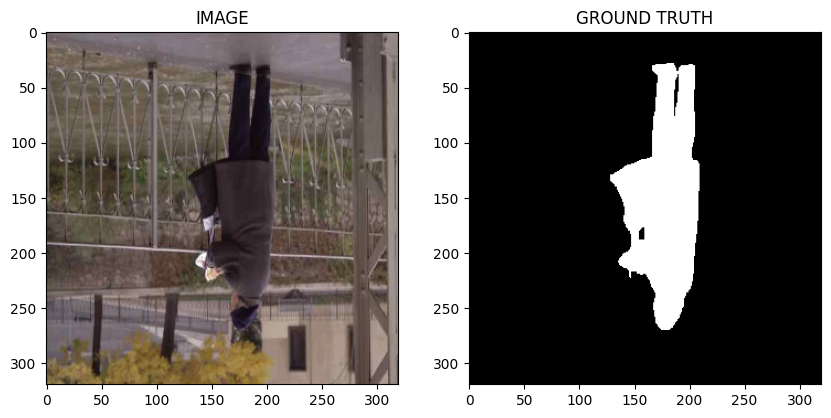

In [91]:
idx = 4

image, mask = dataset_train[idx]
show_image(image, mask)

In [113]:
#BATCHING
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE)

In [96]:
print(f'# of batches for training: {len(train_loader)}')
print(f'# of batches for testing: {len(test_loader)}')

# of batches for training: 15
# of batches for testing: 4


# Segmentation Model

In [99]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [104]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER_NAME,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )


  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [106]:
model = SegmentationModel()
model.to(DEVICE);

# Model training and testing

In [109]:
def train_func(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in data_loader:
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [110]:
def eval_func(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in data_loader:
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

In [111]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [121]:
#TRAINING MODEL
best_testing_loss = np.inf

for i in range(EPOCHS):
  train_loss = train_func(train_loader, model, optimizer)
  testing_loss = eval_func(test_loader, model)

  if testing_loss < best_testing_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_testing_loss = testing_loss

  print(f'Epoch: {i+1} \n Training loss: {train_loss} \n Testing loss: {testing_loss}')

Epoch: 1 
 Training loss: 0.09948117037614186 
 Testing loss: 0.16487951762974262
Epoch: 2 
 Training loss: 0.090908216436704 
 Testing loss: 0.15502599626779556
Epoch: 3 
 Training loss: 0.11071200569470724 
 Testing loss: 0.18685537204146385
Epoch: 4 
 Training loss: 0.12313093294699987 
 Testing loss: 0.23304763063788414
Epoch: 5 
 Training loss: 0.11162488907575607 
 Testing loss: 0.21311542391777039
Epoch: 6 
 Training loss: 0.1016214668750763 
 Testing loss: 0.17941423878073692
Epoch: 7 
 Training loss: 0.08776046534379324 
 Testing loss: 0.17031629011034966
Epoch: 8 
 Training loss: 0.08694587548573812 
 Testing loss: 0.22571944072842598
Epoch: 9 
 Training loss: 0.08231522639592488 
 Testing loss: 0.17923160828649998
Epoch: 10 
 Training loss: 0.07343280638257663 
 Testing loss: 0.1930050104856491
Epoch: 11 
 Training loss: 0.06957430765032768 
 Testing loss: 0.16806998662650585
Epoch: 12 
 Training loss: 0.06547146886587143 
 Testing loss: 0.16410135105252266
Epoch: 13 
 Train

In [122]:
#INFERENCE
idx = 10

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = dataset_test[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

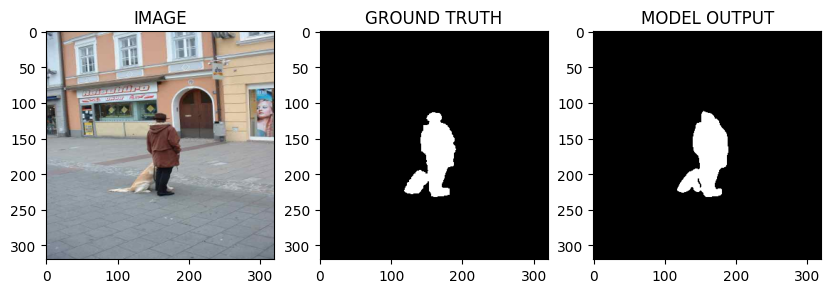

In [125]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))